# REINFORCE on CartPole-v0

* Armando Ordorica
* Aug 2023
* APS 1080
* 1005592164

## REINFORCE
---
### REINFORCE agent on OpenAI Gym's CartPole-v0 environment

For summary, The **REINFORCE** algorithm ([Williams, 1992](https://link.springer.com/content/pdf/10.1007/BF00992696.pdf)) is a monte carlo variation of policy gradient algorithm in RL. The agent collects the trajectory of an episode from current policy. Usually, this policy depends on the policy parameter which denoted as $\theta$. Actually, REINFORCE is acronym for "**RE**ward **I**ncrement = **N**onnegative **F**actor * **O**ffset **R**einforcement * **C**haracteristic **E**ligibility"

### Import the Necessary Packages

In [1]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
torch.manual_seed(0)

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


device(type='cpu')

### Instantiate the Environment and Agent

CartPole environment is very simple.

In [3]:
env = gym.make('CartPole-v0')
env.seed(0)

print('observation space:', env.observation_space)
print('action space:', env.action_space)

observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
action space: Discrete(2)


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` i

### Define Policy
Unlike value-based method, the output of policy-based method is the probability of each action. It can be represented as policy. So activation function of output layer will be softmax, not ReLU.

In [14]:
class Policy(nn.Module):
    def __init__(self, state_size=4, action_size=2, hidden_size=32):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        # we just consider 1 dimensional probability of action
        return F.softmax(x, dim=1)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)

### REINFORCE

The `reinforce` function you provided is an implementation of the REINFORCE algorithm, which is a Monte Carlo policy gradient method. Let's break down the code step-by-step:

1. **Initialization**:
    - `scores_deque` is a double-ended queue that will store the most recent 100 episode scores to keep track of the average performance over the last 100 episodes.
    - `scores` is a list that will store the total reward for each episode.
    - The parameters to this function are:
      - `policy`: The policy network.
      - `optimizer`: The optimization algorithm to update the policy's parameters.
      - `n_episodes`: The number of episodes to run.
      - `max_t`: The maximum number of time steps per episode.
      - `gamma`: The discount factor for future rewards.
      - `print_every`: How often to print the average score.

2. **For Each Episode**:
    - Reset the environment to get the initial state.
    - `saved_log_probs` will store the log probabilities of actions taken in the episode.
    - `rewards` will store the rewards collected in the episode.

3. **Collect Trajectory**:
    - For each time step in the episode, the policy chooses an action based on the current state. The environment then returns a reward and the next state. These are stored in the aforementioned lists.
    - If the episode ends (`done` becomes `True`), exit the loop.

4. **Post-Episode Processing**:
    - The total reward for the episode is stored in `scores` and `scores_deque`.
    - The total expected reward is recalculated with a discount factor using the `discounts` list. The total discounted reward `R` is the dot product of `discounts` and `rewards`.
    - The policy loss is computed by summing the negative product of the stored log probabilities and the discounted reward `R`.
    - Using backpropagation, the optimizer updates the policy's parameters to maximize the expected reward (gradient ascent).

5. **Printing and Break Conditions**:
    - Every `print_every` episodes, the average score over the last 100 episodes is printed.
    - If the average score over the last 100 episodes reaches 195.0, a print statement announces that the environment has been "solved", and the loop exits.

6. **Return**:
    - The function returns the `scores` list, which contains the total reward for each episode.

Overall, this code is a standard REINFORCE implementation for environments where the goal is to maximize some cumulative reward over time. In the context of the cart-pole problem in OpenAI Gym, an average score of 195.0 over 100 episodes is considered "solving" the environment.


In [15]:
def reinforce(policy, optimizer, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    # Initialize a deque to store the last 100 episode scores for performance evaluation
    scores_deque = deque(maxlen=100)
    # List to store scores of all episodes
    scores = []

    # Iterate through all episodes
    for e in range(1, n_episodes):
        # List to store log probabilities of actions taken during the episode
        saved_log_probs = []
        # List to store rewards received during the episode
        rewards = []

        # Reset the environment to get the initial state
        state = env.reset()

        # Iterate through time steps in each episode
        for t in range(max_t):
            # Get an action from the policy given the current state, and its log probability
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            # Take the chosen action in the environment
            state, reward, done, _ = env.step(action)
            rewards.append(reward)

            # If the episode terminates, break out of the loop
            if done:
                break

        # Store the total reward for this episode in both the deque and the list
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # Calculate the discounted future rewards for each time step
        discounts = [gamma ** i for i in range(len(rewards) + 1)]
        # Calculate the total discounted reward for the episode
        R = sum([a * b for a,b in zip(discounts, rewards)])

        # Calculate the loss for policy update
        policy_loss = []
        for log_prob in saved_log_probs:
            # Multiply negative log probability with the discounted reward (for gradient ascent)
            policy_loss.append(-log_prob * R)
        # Aggregate the individual losses into a single value
        policy_loss = torch.cat(policy_loss).sum()

        # Perform backpropagation to adjust the policy parameters
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        # Print average score every 'print_every' episodes
        if e % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(e, np.mean(scores_deque)))

        # Check if the environment is solved (average score >= 195.0 over the last 100 episodes)
        if np.mean(scores_deque) >= 195.0:
            print('Environment solved in {:d} episodes ... \tAverage Score: {:.2f}'.format(e - 100, np.mean(scores_deque)))
            break

    # Return the scores of all episodes
    return scores


### Run

In [16]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
scores = reinforce(policy, optimizer, n_episodes=2000)

Episode 100	Average Score: 11.28
Episode 200	Average Score: 12.00


Exception ignored in: <function VideoRecorder.__del__ at 0x7dc9e355b400>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py", line 269, in __del__
    self.close()
  File "/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py", line 228, in close
    if self.encoder:
AttributeError: 'VideoRecorder' object has no attribute 'encoder'


Episode 300	Average Score: 22.38
Episode 400	Average Score: 20.62
Episode 500	Average Score: 29.91
Episode 600	Average Score: 35.71
Episode 700	Average Score: 26.47
Episode 800	Average Score: 22.83
Episode 900	Average Score: 47.16
Episode 1000	Average Score: 58.51
Episode 1100	Average Score: 62.45
Episode 1200	Average Score: 74.39
Episode 1300	Average Score: 86.17
Episode 1400	Average Score: 74.35
Episode 1500	Average Score: 66.37
Episode 1600	Average Score: 75.85
Episode 1700	Average Score: 111.89
Episode 1800	Average Score: 121.56
Episode 1900	Average Score: 109.36


### Plot the learning progress

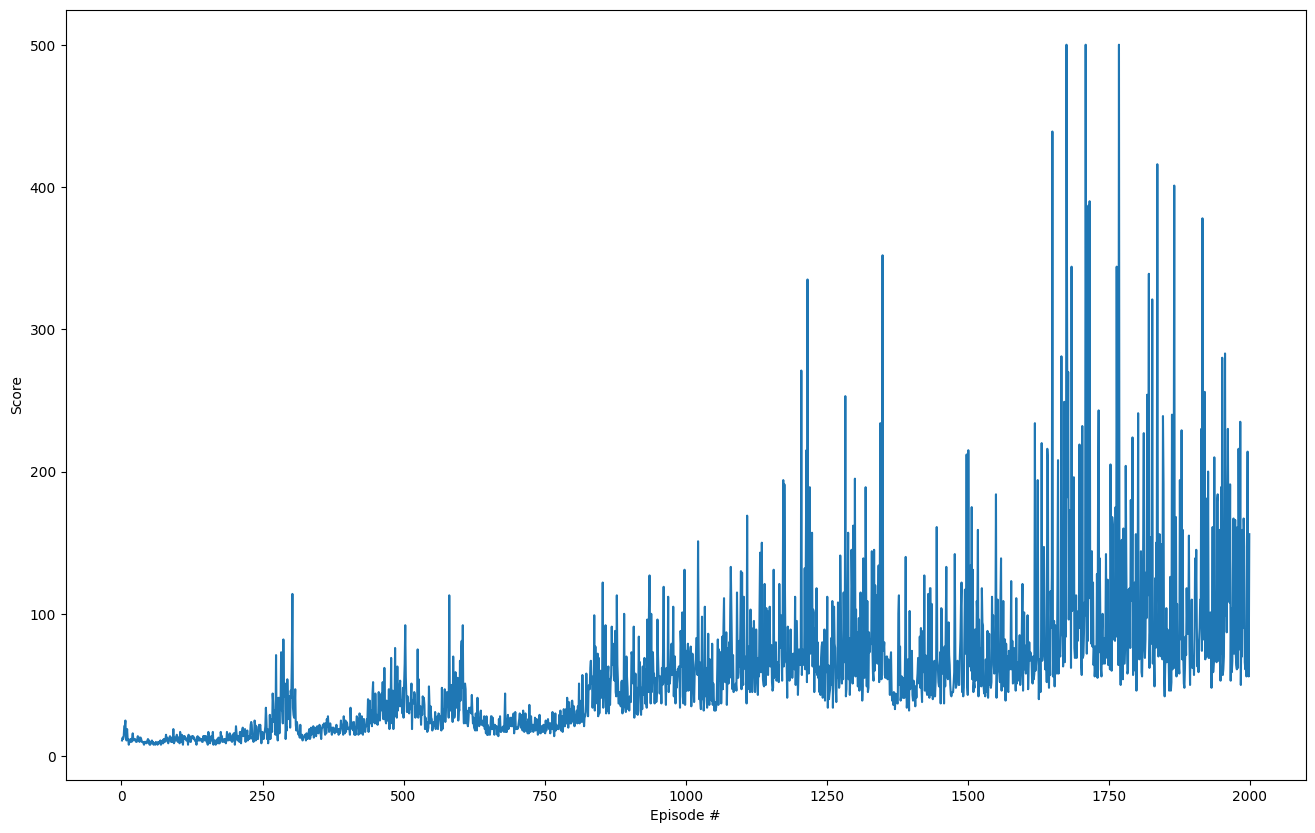

In [17]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Animate it with Video

In [8]:
def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(policy, env_name):
    env = gym.make(env_name)
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state = env.reset()
    done = False
    for t in range(1000):
        vid.capture_frame()
        action, _ = policy.act(state)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        if done:
            break
    vid.close()
    env.close()

In [9]:
show_video_of_model(policy, 'CartPole-v0')

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


FileNotFoundError: ignored

In [10]:
show_video('CartPole-v0')

Could not find video
